<a href="https://colab.research.google.com/github/martinnishant/Eda_workfile/blob/main/Generating_names_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from io import open
import glob
import os
import unicodedata
import string

In [2]:
all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1

In [3]:
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

In [4]:
# Read a file and split into lines
def readLines(filename):
    with open(filename, encoding='utf-8') as some_file:
        return [unicodeToAscii(line.strip()) for line in some_file]


In [11]:
category_lines = {}
all_categories = []

for filename in findFiles('*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

if n_categories == 0:
    raise RuntimeError('Data not found. Make sure that you downloaded data '
        'from https://download.pytorch.org/tutorial/data.zip and extract it to '
        'the current directory.')

print('# categories:', n_categories, all_categories)
print(unicodeToAscii("O'Néàl"))

# categories: 18 ['Chinese', 'Dutch', 'Korean', 'English', 'Spanish', 'French', 'Japanese', 'Portuguese', 'Italian', 'German', 'Arabic', 'Russian', 'Vietnamese', 'Scottish', 'Czech', 'Greek', 'Irish', 'Polish']
O'Neal


## Creating a Network


In [14]:
import torch
import torch.nn as nn

class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(RNN, self).__init__()
    self.hidden_size = hidden_size

    self.i2h = nn.Linear(n_categories + input_size + hidden_size , hidden_size)
    self.i2o = nn.Linear(n_categories + input_size + hidden_size , output_size)
    self.o2o = nn.Linear(hidden_size + output_size, output_size)
    self.dropout = nn.Dropout(0.1)
    self.softmax = nn.LogSoftmax(dim=1)

  def forward(self, category, input, hidden):
    input_combined = torch.cat((category, input, hidden), 1)
    hidden = self.i2h(input_combined)
    output = self.i2o(input_combined)
    output_combined = torch.cat((hidden, output), 1)
    output = self.o2o(output_combined)
    output = self.dropout(output)
    output = self.softmax(output)
    return output, hidden

  def initHidden(self):
    return torch.zeros(1, self.hidden_size)


## Training

### Preparing for training


In [16]:
import random

# Random item from a list
def randomChoice(l):
  return l[random.randint(0, len(l) - 1)]

# get a random category and random line from that category

def randomTrainingPair():
  category = randomChoice(all_categories)
  line = randomChoice(category_lines[category])
  return category, line


In [37]:
# one hot vector for category
def categoryTensor(category):
  li = all_categories.index(category)
  tensor = torch.zeros(1, n_categories)
  tensor[0][li] = 1
  return tensor


# One_ Hot matrix of first to last letters (not including EOS) for input
def inputTensor(line):
  tensor = torch.zeros(len(line), 1, n_letters)
  for li in range(len(line)):
    letter = line[li]
    tensor[li][0][all_letters.find(letter)] = 1
  return tensor

# LongTensor of secodn letter to end(EOS) for target

def targetTensor(line):
  letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
  letter_indexes.append(n_letters - 1) #EOS
  return torch.LongTensor(letter_indexes)

In [38]:
# make category, imput and target tensors from a random category, line pair
def randomTrainingExample():
  category, line = randomTrainingPair()
  category_tensor = categoryTensor(category)
  input_line_tensor = inputTensor(line)
  target_line_tensor = targetTensor(line)
  return category_tensor, input_line_tensor, target_line_tensor

### Training the Network

In [42]:
criterion = nn.NLLLoss()
learning_rate = 0.0005

def train(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)  # This is fine

    hidden = rnn.initHidden()

    rnn.zero_grad()

    loss = 0  # Start with a scalar

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l  # Add the real loss

    loss.backward()

    for p in rnn.parameters():  # typo: 'paremeters' → 'parameters'
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item() / input_line_tensor.size(0)

In [43]:
import time
import math

def timeSince(since):
  now = time.time()
  s = now - since
  m = math.floor(s / 60)
  return '%dm %ds' % (m, s)

In [44]:
rnn = RNN(n_letters, 128, n_letters)

n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0 # Resset every '' plot_every'' "iters"

start  = time.time()

for iter in range(1, n_iters + 1):
  output, loss = train(*randomTrainingExample())
  total_loss += loss

  if iter % print_every == 0:

    print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

  if iter % plot_every == 0:
    all_losses.append(total_loss / plot_every)
    total_loss = 0


0m 19s (5000 5%) 3.1580
0m 40s (10000 10%) 2.7281
1m 60s (15000 15%) 2.3775
1m 81s (20000 20%) 2.0030
1m 102s (25000 25%) 2.2856
2m 122s (30000 30%) 2.1721
2m 143s (35000 35%) 2.5461
2m 164s (40000 40%) 2.4157
3m 183s (45000 45%) 2.4528
3m 204s (50000 50%) 2.8692
3m 225s (55000 55%) 2.4862
4m 245s (60000 60%) 2.8772
4m 266s (65000 65%) 2.2484
4m 287s (70000 70%) 2.3282
5m 307s (75000 75%) 2.9329
5m 328s (80000 80%) 2.4381
5m 348s (85000 85%) 1.1982
6m 369s (90000 90%) 2.4490
6m 390s (95000 95%) 3.4194
6m 409s (100000 100%) 1.9872


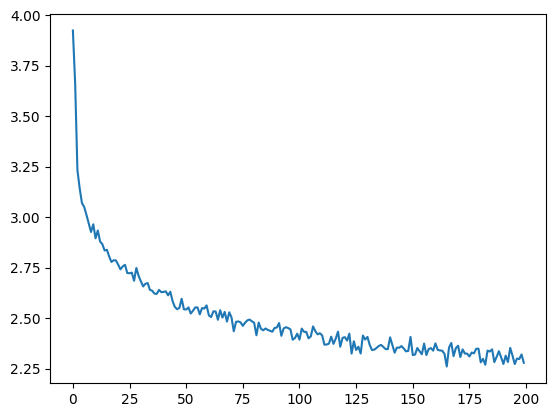

In [45]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(all_losses)
#

In [46]:
max_length = 20

# Sample from a category and starting letter
def sample(category, start_letter='A'):
    with torch.no_grad():  # no need to track history in sampling
        category_tensor = categoryTensor(category)
        input = inputTensor(start_letter)
        hidden = rnn.initHidden()

        output_name = start_letter

        for i in range(max_length):
            output, hidden = rnn(category_tensor, input[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input = inputTensor(letter)

        return output_name

# Get multiple samples from one category and multiple starting letters
def samples(category, start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(category, start_letter))

samples('Russian', 'RUS')

samples('German', 'GER')

samples('Spanish', 'SPA')

samples('Chinese', 'CHI')

Rovanton
Uanton
Shanton
Garten
Eren
Romer
Sallo
Para
Allan
Chan
Han
Iun
